<H1><center><font color='limegreen'>E-commerce Customer Churn Analysis</font>
<br>----------

By : Fathur Rizky Maulana

-------------------------

## **Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

----
----

### **`Initial Setup`**

In [44]:
# Import library eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Membuat grafik
import seaborn as sns #Membuat grafik
import missingno as msno #Cek missing value
import phik #Cek phik korelasi
from sklearn.experimental import enable_iterative_imputer #Melakukan imputasi
from sklearn.impute import IterativeImputer #Melakukan iterative imputasi

# Import library sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score #Membagi data train dan data test
from pycaret.classification import * #Men-setting parameter dasar menggunakan pycaret
from sklearn.base import BaseEstimator, TransformerMixin #Membuat estimator
from sklearn.preprocessing import FunctionTransformer #Meneruskan argumen objek fungsi dan mengembalikan hasil dari fungsi ini
from sklearn.compose import ColumnTransformer #Melakukan kolom transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer, classification_report

# Import library uji statistics
from scipy.stats import ks_2samp # Uji KS untuk melihat distorsi sebelum dan sesudah handling outlier

# Import library modeling
import pycaret
from pycaret.internal.preprocess.transformers import TransformerWrapper
from pycaret.internal.preprocess.transformers import RemoveOutliers

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

import warnings
warnings.filterwarnings('ignore')


import matplotlib
min_val, max_val = 0, 0.8
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
custom_summer = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

In [2]:
# Kumpulan Fungsi

# Fungsi untuk melakukan imputasi
def imputasi(df_seen, df_unseen, X_train, X_val, feature):
    imputerCont = IterativeImputer(max_iter=10, random_state=0)
    imputerCont.fit(df_seen[feature])
    df_seen[feature] = imputerCont.transform(df_seen[feature])
    df_unseen[feature] = imputerCont.transform(df_unseen[feature])
    X_train[feature] = imputerCont.transform(X_train[feature])
    X_val[feature] = imputerCont.transform(X_val[feature])
    return df_seen, df_unseen, X_train, X_val

### **`Business Problem Understanding`**

**Context**

Berdasarkan definisi dari [Cambridge Dictionary](https://dictionary.cambridge.org/dictionary/english/churn-rate), istilah *Churn* adalah persentase dari pelanggan yang berhenti membeli produk atau layanan dari perusahaan tertentu, dihitung untuk periode waktu tertentu.

Dalam konteks bisnis *e-commerce*, istilah "***Churn***" mengacu pada keadaan dimana pelanggan berhenti menjadi pelanggan atau tidak lagi membeli produk pada *e-commerce* tersebut selama periode waktu tertentu. ***Churn Rate*** adalah salah satu metrik penting pada bisnis *e-commerce* karena metrik tersebut dapat menunjukkan banyak hal seperti tingkat kepuasan pelanggan, keterlibatan, dan loyalitas pelanggan terhadap *e-commerce*. Tingkat *churn rate* yang tinggi dapat mengindikasikan bahwa pelanggan tidak puas dengan produk atau layanan yang ditawarkan, atau mereka menemukan alternatif yang lebih baik di tempat lain.

**Problem Statement**

Terdapat perusahaan *e-commerce* yang memiliki masalah pada bisnis yang dijalankan-nya, pada *e-commerce* tersebut terdapat beberapa pelanggan yang sudah tidak lagi menjadi pelanggan atau tidak lagi berbelanja di *e-commerce* tersebut (***`Churn`***). *e-commerce* tersebut saat ini memiliki ***churn rate*** yang cukup tinggi, yaitu sebesar **16,33%** dari total pelanggan [(perhitungan *churn rate*)](https://www.paddle.com/resources/calculate-churn-rate), dimana nilai ideal untuk ***churn rate*** saat ini hanya berkisar 5% sampai 7% per tahun [(Monique Danao,2023)](https://www.forbes.com/advisor/business/churn-rate/). Oleh karena itu, hal tersebut akan berdampak pada jumlah pendapatan yang diterima oleh *e-commerce* tersebut, karena *churn rate* yang tinggi akan diikuti dengan penurunan pendapatan perusahaan.

Di sisi lain, ketika perusahaan salah memprediksi pelanggan ***Churn*** atau **tidak *Churn***, hal tersebut akan memberikan masalah kepada perusahaan. Contohnya, jika perusahaan akan melakukan usaha marketing ke semua pelanggan, maka besaran biaya yang dikeluarkan akan menjadi tinggi. Studi menunjukkan bahwa biaya untuk mendapatkan pelanggan baru adalah 5 sampai 25 kali lebih tinggi daripada biaya untuk mempertahankan pelanggan lama ([Amy Gallo, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers)).Adapun jika perusahaan hanya memberikan usaha marketing ke sebagian pelanggan, maka perusahaan bisa kehilangan pelanggan yang sebenarnya berpotensi menjadi pelanggan yang **tidak *Churn*** (`Loyal`). Kemudian biaya yang dikeluarkan perusahaan untuk membawa pelanggan baru ke tingkat yang sama dengan pelanggan loyal bisa 16 kali lebih banyak [(Sumber)](https://media.bain.com/Images/Value_online_customer_loyalty_you_capture.pdf)

Sehingga pernyataan masalah pada kasus ini adalah bagaimana perusahaan dapat memprediksi pelanggan *churn*  agar promo, diskon, iklan dan usaha marketing lainnya dialokasikan secara lebih efisien sehingga perusahaan tidak perlu mengeluarkan biaya terlalu besar?

**Project Stakeholders:**

Pihak stakeholders yang terlibat dan yang akan menggunakan model dari analisis ini adalah:
* ***Sales & Marketing Team***: Tim ini akan bertanggung jawab dalam mengembangkan dan merencanakan usaha marketing serta mengimplementasikan kepada pelanggan secara tepat dalam upaya memaksimalkan pendapatan perusahaan.
* ***Operations Team***: Tim ini akan bertanggung jawab dalam mengkoordinasikan serta mengurus rincian operasi, mengevaluasi gambaran besar operasi, dan memastikan bahwa area bisnis berjalan semulus dan seefektif mungkin.
* ***Finance Team***: Tim ini akan bertanggung jawab dalam mengatur keuangan perusahaan yang diakibatkan oleh usaha marketing.

Ketiga peran diatas memiliki tujuan yang sama yaitu memaksimalkan pendapatan perusahaan dengan tepat

**Goals**

*Stakeholders* dapat mengetahui serta memprediksi karakteristik dari jenis pelanggan yang ***Churn*** dan yang **Tidak *Churn***, sehingga mereka dapat menerapkan usaha marketing dengan tepat sasaran. Hal ini dapat menurunkan biaya yang diakibatkan oleh usaha marketing tersebut (*biaya akuisisi pelanggan*) dan diharapkan juga dapat meningkatkan profit dengan mempertahankan pelanggan yang loyal.

**Analytic Approach**

Metode dalam melakukan analisis *customer churn* ini menggunakan **analisis prediktif**, kemudian membangun model **`klasifikasi`** yang akan membantu *stakeholders* untuk dapat memprediksi jenis pelanggan *Churn* (tidak loyal) dan Tidak *Churn* (loyal) berdasarkan data historis.

**Metric Evaluation**

Karena kita akan memfokuskan pelanggan yang ***churn*** (**`Tidak Loyal`**), maka target yang kita tetapkan adalah sebagai berikut:

**Target**:   
`0` : pelanggan tidak *churn* (`Loyal`) Negative
<br>
`1` : pelanggan *churn* (`Tidak Loyal`) Positive

**Metric Evaluation**:

|                       | ***Not Churn*-`Pred`** | ***Churn*-`Pred`** |
| --------------------- | ---------------------- | ------------------ |
| ***Not Churn*-`Act`** |           TN           |          FP        |
| ***Churn*-`Act`**     |           FN           |          TP        |

**`Type 1 Error`** : **False Positive**
<br>
`Interpretasi`: pelanggan yang kenyataannya not *churn* (**Loyal**), tapi terprediksi sebagai pelanggan *churn* (**Tidak loyal**) 
<br>
`Konsekuensi`: 
* Perusahaan akan mengeluarkan biaya akuisisi pelanggan ([CAC](https://www.paddle.com/resources/customer-acquisition-cost)) untuk pelanggan yang tidak tepat
* Mengeluarkan biaya akuisisi pelanggan ([Customer Acquisition Cost (CAC)](https://scalecrush.io/blog/average-customer-acquisition-cost-ecommerce#:~:text=The%20average%20CAC%20on%20the%20eCommerce%20scene%20is%20around%20%2445%20to%20%2450.&text=Remember%2C%20there%20is%20no%20hard,acquisition%20is%20a%20great%20decision.)) untuk pelanggan yang tidak *churn* => $50 (*worst case*)

**`Type 2 Error`** : **False Negative**
<br>
`Interpretasi`: pelanggan yang kenyataannya *churn* (**Tidak Loyal**), tapi terprediksi sebagai pelanggan not *churn* (**loyal**)
<br>
`Konsekuensi`: 
* Perusahaan tidak mengeluarkan biaya untuk akuisisi pelanggan, namun perusahaan akan kehilangan potensi pelanggan yang bisa saja menjadi pelanggan yang loyal.

Berdasarkan konsekuensi diatas, menurut langkah yang tepat untuk pemilihan model adalah model yang **mengurangi jumlah pengeluaran biaya akuisisi pelanggan yang tidak tepat**, Jadi kita ingin sebanyak mungkin memprediksi `Kelas Negatif` yang benar Negatif, dan sesedikit mungkin prediksi `False Positif`. Jadi metric utama yang akan digunakan adalah Recall positif (false positif turun), Precision positif (sebanyak mungkin prediksi positif mana yang benar positif) (gabisa pake ROC-AUC karena data imbalance)

### **`Data Understanding`**

Dataset dan deskripsi dapat di akses pada link berikut:
<br>
[E-commerce Customer Churn](https://drive.google.com/drive/folders/1PITb78NtK9Ra6wOkQdXCIgItZkj29Ves)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `Tenure` | Masa tenure pelanggan (`bulan`) |
| `WarehouseToHome` | Jarak antara warehouse ke rumah pelanggan (`mil`) |
| `NumberOfDeviceRegistered` | Jumlah perangkat yang terdaftar (`unit`) |
| `PreferedOrderCat` | Kategori yang disukai pelanggan bulan lalu |
| `SatisfactionScore` | Skor kepuasan pelanggan terhadap service |
| `MaritalStatus` | Status pernikahan pelanggan |
| `NumberOfAddress` | Jumlah alamat yang terdaftar |
| `Complain` | Adakah complain dalam satu bulan terakhir |
| `DaySinceLastOrder` | Hari sejak pemesanan terakhir (`hari`) |
| `CashbackAmount` | Rata-rata cashback bulan lalu (`$`) |
| `Churn` | Status churn pelanggan |

**`Complain`** == `0` : Tidak Ada *complain*, `1` : ada *complain*
<br>
**`Churn`** == `0` : Tidak *churn*, `1` : *Churn*

In [3]:
# Import file CSV

df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-3\data\\raw\data_ecommerce_customer_churn.csv")
print(f'Jumlah baris dan kolom: {df.shape}')

df.sample(10)

Jumlah baris dan kolom: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2158,1.0,21.0,4,Mobile Phone,1,Married,7,1,5.0,149.36,1
3440,24.0,8.0,5,Laptop & Accessory,4,Married,6,0,2.0,154.82,0
3856,0.0,6.0,4,Laptop & Accessory,5,Single,2,0,7.0,142.94,0
1488,11.0,13.0,3,Laptop & Accessory,5,Married,6,1,8.0,184.74,0
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3760,1.0,24.0,4,Mobile Phone,4,Divorced,2,1,2.0,155.58,0
2803,4.0,NaN,4,Mobile,3,Married,4,0,2.0,123.29,0
2019,27.0,14.0,4,Others,3,Married,5,0,8.0,311.06,0
2258,4.0,12.0,5,Laptop & Accessory,3,Married,3,0,3.0,186.18,0
466,9.0,14.0,4,Mobile Phone,3,Married,3,0,1.0,149.04,0


#### **Initial Assessment**

In [4]:
# Check karakteristik dataset

pd.DataFrame(
        {
        'feature': df.columns.values,
        'data_type': df.dtypes.values,
        'total_row': df.isna().count().values,
        'total_null': df.isna().sum().values,
        '%null_value': df.isna().mean().values * 100,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns]
        }
    )

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,Tenure,float64,3941,194,4.922608,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,3941,169,4.288252,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,3941,0,0.000000,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,3941,0,0.000000,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,3941,0,0.000000,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,3941,0,0.000000,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,3941,0,0.000000,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,3941,0,0.000000,2,"[0, 1]"
8,DaySinceLastOrder,float64,3941,213,5.404720,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,3941,0,0.000000,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


__Insight :__
<br>

* Numerical Variable:
<br>
    - `Discrete` : NumberOfDeviceRegistered, NumberOfAddress
<br>
    - `Continue` : Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount
* Categorical variable:
<br>
    - `Nominal` : PreferedOrderCat, MaritalStatus, **Churn**
<br>
    - `Ordinal` : SatisfactionScore, Complain
* `Target`: Churn
* Terdapat total 3.941 jumlah baris pada dataset
* Tipe data untuk setiap variabel sudah sesuai
* Terdapat missing value pada kolom "*Tenure*" sebanyak 194 data (4.92%), "*WarehouseToHome*" sebanyak 169 data (4.29%), dan "*DaySinceLastOrder*" sebanyak 213 data (5.40%). (*analisis lebih lanjut*)
* Pada kolom "*CashbackAmount*" memiliki unique value yang sangat banyak sebesar 2335 unique value. Maka kita akan kelompokan berdasarkan kelasnya

Lalu kita akan coba melihat statistik deskriptif sederhana dari dataset ini

In [5]:
# Deskriptif statistik

display(
    # numerical variable
    df.describe(),
    # categorical variable
    df.describe(include='object')
)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


__Insight :__
* Pesebaran nilai pada kolom ***CashbackAmount*** cukup besar, ditunjukan dari nilai standar deviasi 48.79

#### **Numerical variable**

##### **Numerikal Diskrit** (*NumberOfDeviceRegistered, NumberOfAddress*)

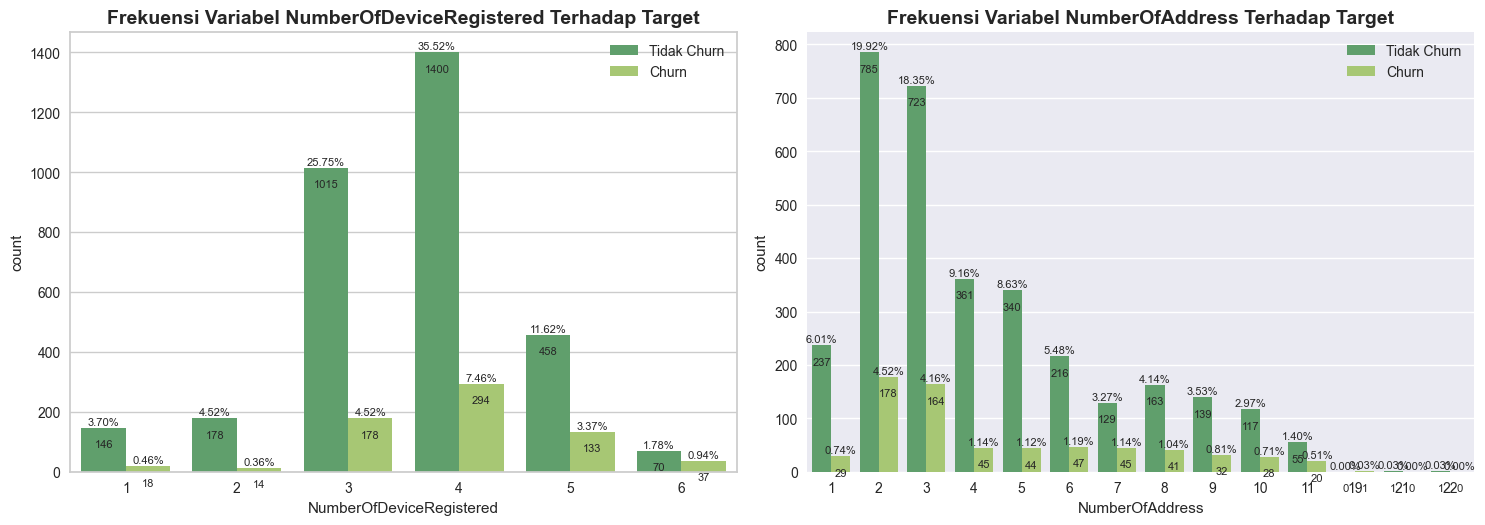

In [6]:
# Cek variabel numerikal diskrit

diskrit = ["NumberOfDeviceRegistered", "NumberOfAddress"]

plt.figure(figsize=(15,10))
cmap = plt.get_cmap("summer")

a=1
for i in diskrit:
    plt.subplot(2,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center', size=8,)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show()

__Insight :__
* Pada kolom ***NumberOfDeviceRegistered***, pelanggan dengan jumlah device terdaftar lebih dari 2 device cenderung akan *churn* (*diatas 4% dari total pelanggan*). Hal ini mungkin karena pelanggan memiliki banyak opsi e-commerce dan pelanggan tersebut dapat berpindah-pindah e-commerce
* Pada kolom ***NumberOfAddress***, pelanggan yang memiliki jumlah address 2 dan 3 akan cenderung churn (*diatas 4% dari total pelanggan*). Untuk jumlah address lebih dari 11, kemungkinan merupakan nilai outlier, maka perlu dianalisis kembali

##### **Numerikal Kontinyu** (*Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount*)

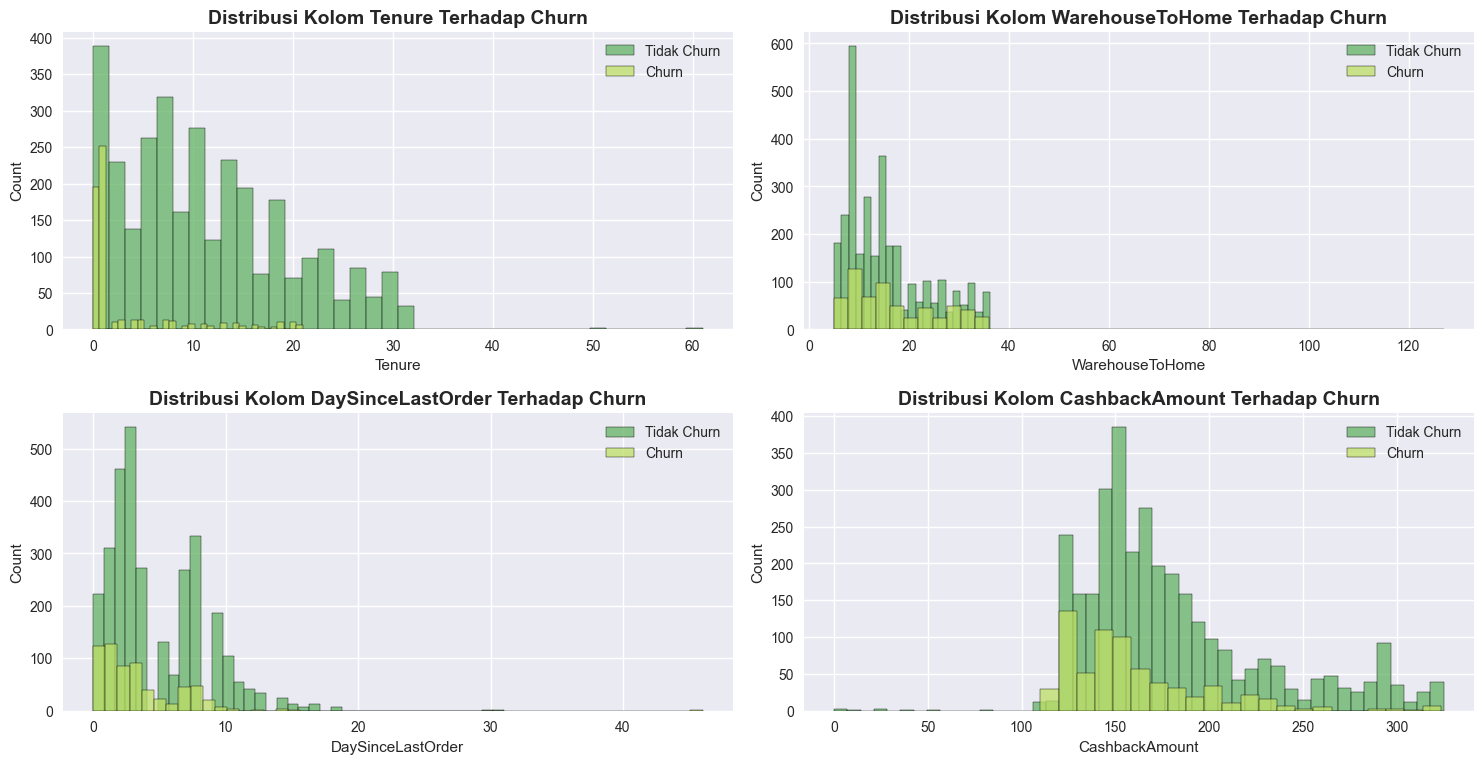

In [7]:
# Cek variabel numerikal kontinyu

kontinu = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in kontinu:
    plt.subplot(4,2,a)
    sns.histplot(x=df[df["Churn"]==0][i],color=cmap([100]))
    sns.histplot(x=df[df["Churn"]==1][i],color=cmap([190]))
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.title(f"Distribusi Kolom {i} Terhadap Churn", fontsize=14, weight='bold')
    a+=1

plt.show()

__Insight :__
* Pada kolom ***Tenure***, pelanggan churn terjadi pada awal bulan pemakaian yaitu di bulan ke-0 hingga bulan ke-2. Hal tersebut kemungkinan bisa terjadi dikarenakan pelanggan masih beradaptasi dengan platform e-commerce dan merasa tidak cocok dengan platform tersebut
* Pada kolom ***WarehouseToHome***, pelanggan dengan jarak gudang ke rumah kurang dari 20 mil cenderung churn. Hal tersebut mungkin dikarenakan ongkos kirim yang terlalu mahal untuk jarak yang dekat dengan rumah
* Pada kolom ***DaySinceLastOrder***, pelanggan terbanyak churn terjadi satu sampai dua hari setelah melakukan order. Hal tersebut mungkin terjadi dikarenakan pelanggan hanya membutuhkan barang dari e-commerce dan tidak tertarik dengan platform e-commerce tersebut
* Pada kolom ***CashbackAmount*** (nilai dibawah 100 dolar kemungkinan adalah nilai outlier), semakin rendah cashback yang diberikan maka semakin banyak pelanggan yang churn
* Pada **semua kolom numerikal kontinyu** pesebaran data tidak merata, hal ini terjadi karena terdapat rare label. Maka perlu dilakukan analisa kembali

#### **Categorical variable**

##### **Kategorikal Nominal** (*PreferedOrderCat, MaritalStatus, Churn*)

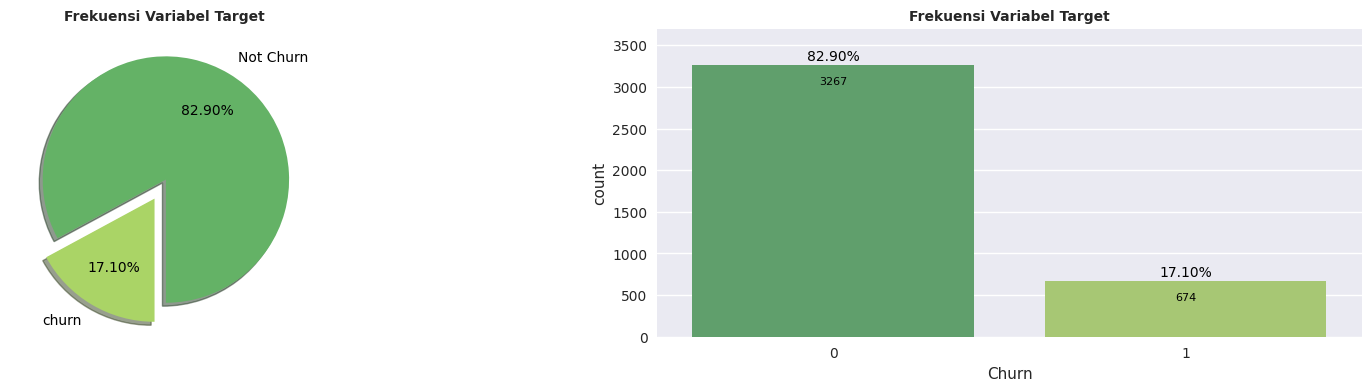

In [8]:
# Melihat kategori Churn

# Mengatur proporsi grafik
fig, axes = plt.subplots(1, 2, figsize=(20,4))
plt.style.use('default')
cmap = plt.get_cmap('summer')

# create pie chart
temp_df = df.Churn.value_counts(normalize=True) * 100
axes[0].pie(x=[temp_df.loc[0], temp_df.loc[1]], labels=['Not Churn', 'churn'], colors=cmap([100, 170]), autopct='%0.2f%%', 
        startangle=270, pctdistance=0.65, labeldistance=1.15, explode=(0.03, 0.15), shadow=True)
# set title
axes[0].set_title('Frekuensi Variabel Target', fontsize=10, weight='bold')

# create barplot
plt.title("Frekuensi Variabel Target", fontsize=10, weight='bold')
# set title dan 
ax = sns.countplot(data=df, x="Churn", palette="summer")
ax.set_ylim([0, 3700])
# annotation
for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show();

__Insight :__
* Jumlah pengguna yang ***Churn*** (`Tidak Loyal`) sebanyak 674 (17.10%)
* Jumlah pengguna yang **Tidak *Churn*** (`Loyal`) sebanyak 3267 (82.90%)
* Dari dataset terjadi ***Imbalance***, maka kita akan lakukan analisis mendalam

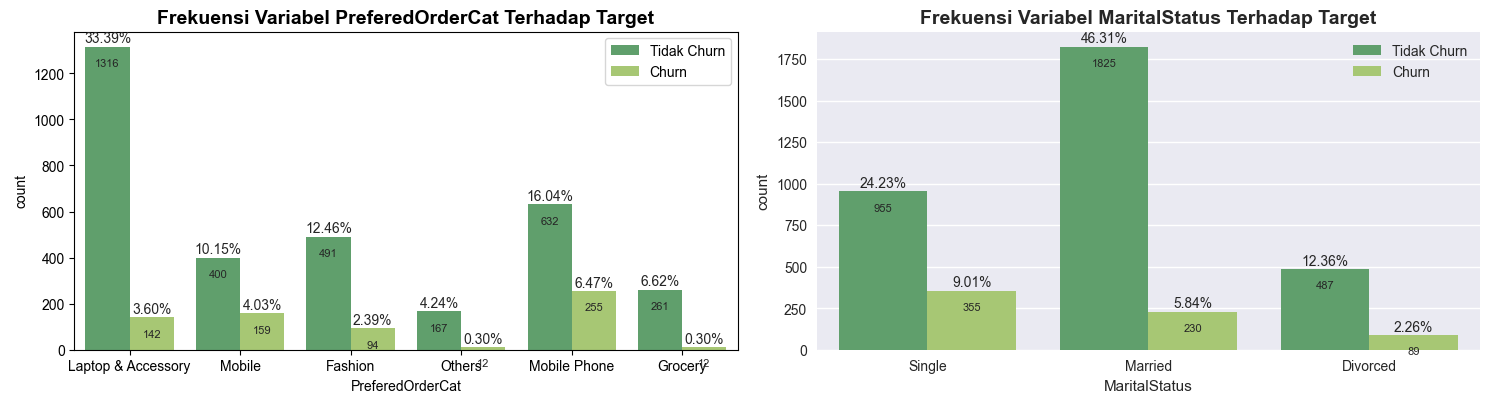

In [9]:
# Cek variabel kategorikal nominal

nominal = ["PreferedOrderCat", "MaritalStatus"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in nominal:
    plt.subplot(4,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show()

__Insight :__
* Kategori "*Mobile*" dan "*Mobile Phone*" bisa memiliki arti yang sama. Kita bisa mengganti kategori "***Mobile***" menjadi "***Mobile Phone***"
* *E-commerce* tersebut didominasi olah pelanggan yang membeli barang elektronik (*Laptop & Accesorry* serta *Mobile Phone*). Hal ini menandakan bahwa kategori tersebut adalah kategori barang favorit
* Kategori "*Mobile Phone*" memiliki jumlah pelanggan *churn* tertinggi sebesar 414 (10.50%) (*setelah kategori "***Mobile***" dan "***Mobile Phone***" digabungkan*) dari total pelanggan. Hal ini berarti pelanggan yang membeli *Mobile Phone* hanya memiliki tujuan untuk membeli barang tersebut saja, dan tidak tertarik untuk membeli kembali di e-commerce
* Pada kolom ***PreferedOrderCat*** karena merupakan feature bertipe kategorikal dan memiliki jumlah kategori yang cukup banyak (5 kategori ***setelah Kategori "*Mobile*" dimasukan ke kategori "*Mobile Phone*"**). Maka kita akan menerapkan ***`Binnary Encoding`*** pada preprocessing data
* Pengguna *e-commerce* terbanyak pada variabel *Marital Status* adalah kategori ***Married*** sebesar 2055 (52.15%)
* Pengguna *e-commerce* dengan *churn* terbanyak adalah ***Single*** sebesar 355 (9.01%) dari total pelanggan
* Pada kolom ***MaritalStatus*** karena merupakan feature bertipe kategorikal dan memiliki jumlah kategori yang cukup sedikit (3 kategori) dan tidak memiliki urutan. Maka kita akan menerapkan ***`One Hot Encoding`*** untuk ***MaritalStatus*** pada preprocessing data

Mengganti kategori ***Mobile*** menjadi kategori ***Mobile Phone***

In [10]:
# Mengganti kategori Mobile menjadi kategori Mobile Phone

df.replace("Mobile", "Mobile Phone", inplace=True)

##### **Kategorikal Ordinal** (*SatisfactionScore, Complain*)

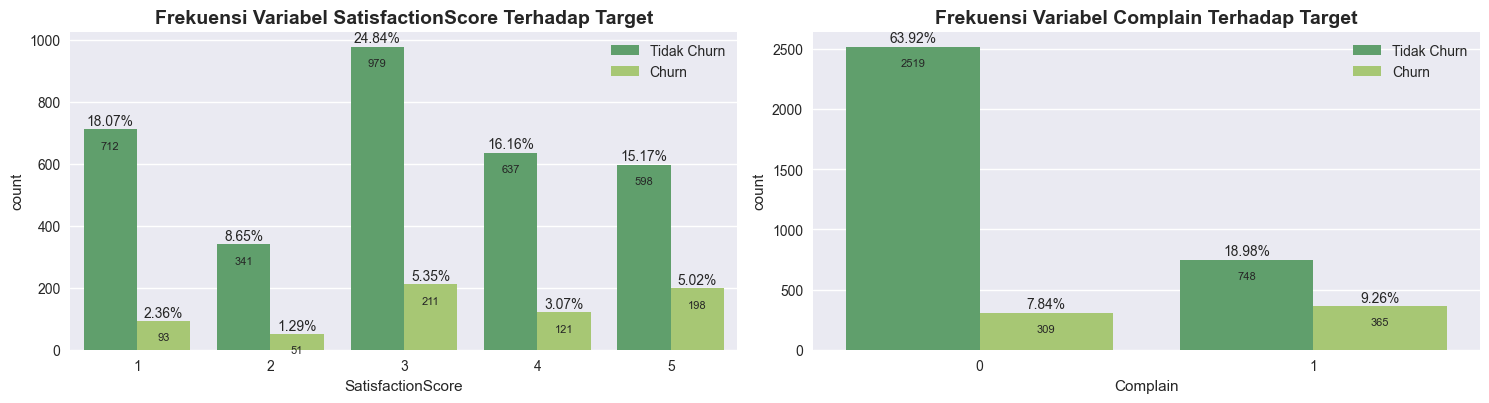

In [11]:
# Cek variabel kategorikal ordinal

ordinal = ["SatisfactionScore", "Complain"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in ordinal:
    plt.subplot(4,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')
        
plt.show()

__Insight :__
* Pada kolom ***SatisfactionScore***, pelanggan yang memilih SatisfactionScore diatas 2 cenderung churn
* Pada kolom ***Complain***, pelanggan yang churn lebih banyak melakukan complain. Hal ini harus menjadi perhatian untuk e-commerce dalam upaya peningkatan kualitas layanan nya 

### **`Data Preprocessing`**

In [12]:
# find the lower bound and upper bound variable

def CheckBound(x):
    Q1 = int(x.quantile([0.25]).values)
    Q3 = int(x.quantile([0.75]).values)
    IQR = Q3-Q1
    LowerBound = Q1-1.5*IQR
    UpperBound = Q3+1.5*IQR
    total = len(df[(x<LowerBound) | (x>UpperBound)])

    result = f'''
        Lower Bound is: {LowerBound}
        Upper Bound is: {UpperBound}
        Total Outlier is: {total}'''
    
    return result

#### **Finding Problematic Data**

##### **> Missing Value**, Deteksi dan kuantifikasi missing value:

Text(0.5, 1.0, 'Cek Missing Value')

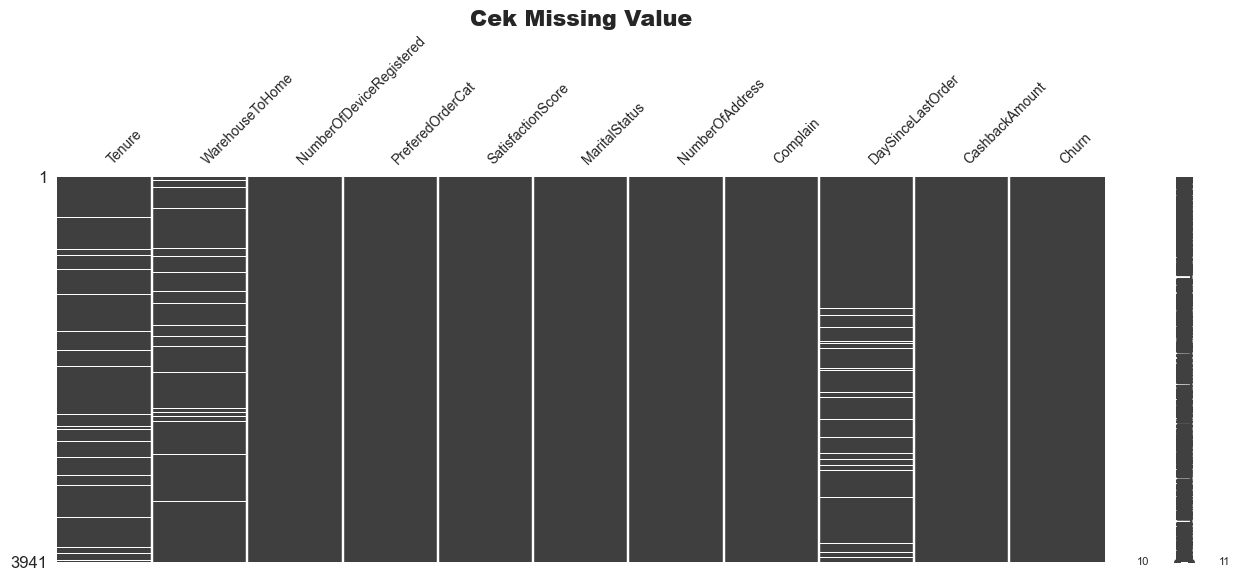

In [13]:
# Cek missing value

msno.matrix(df, figsize=(15,5), fontsize=10)
plt.title("Cek Missing Value", fontsize=16, weight="extra bold")

In [14]:
# Cek jumlah missing value masing-masing kolom

print(df.isna().sum())

# Kalkulasi missing value
print(f'''\nJumlah total missing value: {df.isnull().sum().sum()}
Jumlah baris yang terdapat missing value: {df[df.isnull().any(axis=1)].shape[0]}
Persentase baris dengan missing value: {round(df.isnull().sum().sum()/df.shape[0]*100,2)}%''')

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

Jumlah total missing value: 576
Jumlah baris yang terdapat missing value: 576
Persentase baris dengan missing value: 14.62%


__Insight :__
* Terdapat tiga kolom missing value "***Tenure***"(160), "***WarehouseToHome***"(135), "***DaySinceLastOrder***"(182) (float64)
* Jumlah total missing value adalah 476, dan lokasi missing value di baris yang berbeda-beda (476 baris), dengan presentase missing value 14.56% dari total data tersedia
* Kita tidak bisa lakukan drop missing value (karena jumlah missing value yang cukup besar 14.56%)
* Missing value tidak menunjukan pola tertentu/ acak (**MAR**)
* Perlu analisis lebih lanjut mengenai handling missing value

In [15]:
# # Cek corelations matrix untuk kolom "Tenure", "WarehouseToHome", "DaySinceLastOrder"

# plt.style.use('default')

# fig, ax = plt.subplots(2, 1, figsize=(15, 10))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

# cols = df.columns
# corr = df[cols].phik_matrix()
# corr_mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlGnBu", ax=ax[0])

# sig = df[cols].significance_matrix()
# sig_mask = np.triu(np.ones_like(sig, dtype=bool))
# sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlGnBu", ax=ax[1])

# ax[0].set_title(f"Correlation $\phi_K$")
# ax[1].set_title(f"Significance matrix")



__Insight :__
* Dari 3 kolom yang memiliki mising value ("***Tenure***", "***WarehouseToHome***", "***DaySinceLastOrder***"), tidak ada yang berkorelasi signifikan dengan feature lainnya
* Solution : Lakukan imputasi menggunakan metode **`Multivariate Imputation`**/ **`Iterative Imputer`**

##### **> Outlier,** Deteksi dan kuantifikasi outlier:

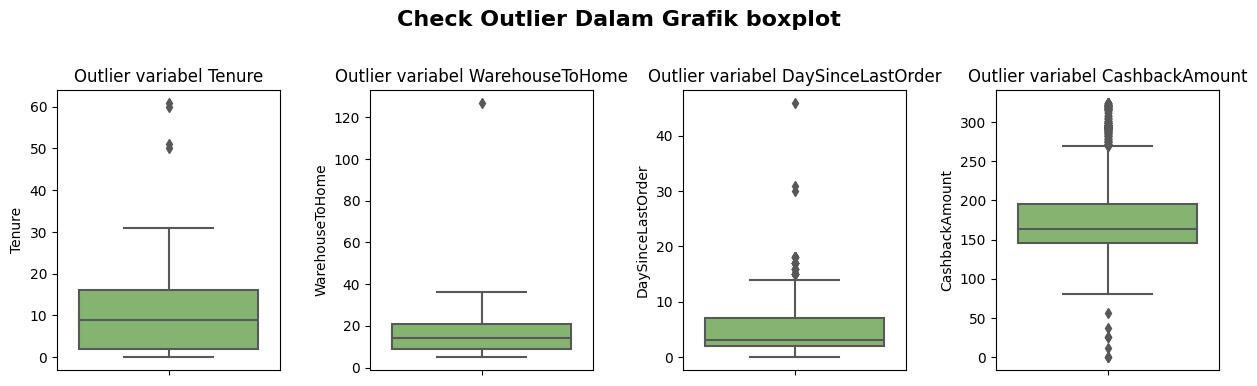

In [16]:
# Cek data outlier untuk continue variable (Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount)

contVar = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.style.use("default")
ax = plt.figure(figsize=(15, 8))
for i in range(0, len(contVar)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[contVar[i]], palette="summer")
    plt.title(f"Outlier variabel {contVar[i]}", fontsize=12, ha="center")

ax.suptitle("Check Outlier Dalam Grafik boxplot", fontsize=16, weight="extra bold")
ax.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4)
plt.show()

In [17]:
# Melihat lower bound, upper bound, outlier, dan persentase outlier

totalOutlier =0
for i in range(0, len(contVar)):
    Q1 = df[contVar[i]].quantile(0.25)
    Q3 = df[contVar[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    condition = (df[contVar[i]]< lower_bound) | (df[contVar[i]]> upper_bound)
    outlier = df.loc[condition, contVar[i]].count()
    totalOutlier+=outlier
    PersentaseOutlier = outlier/df[contVar[i]].count()*100
    print(f"{contVar[i]}\nLower Bound   : {round(lower_bound,2)}\nUpper Bound   : {round(upper_bound,2)}\nJumlah Outlier: {outlier} ({round(PersentaseOutlier,2)}%)\n")

print("==============================")
print(f"Total outlier: {totalOutlier}\nOutlier dalam dataset: {round((totalOutlier/len(df))*100, 2)}%")

Tenure
Lower Bound   : -19.0
Upper Bound   : 37.0
Jumlah Outlier: 4 (0.11%)

WarehouseToHome
Lower Bound   : -9.0
Upper Bound   : 39.0
Jumlah Outlier: 1 (0.03%)

DaySinceLastOrder
Lower Bound   : -5.5
Upper Bound   : 14.5
Jumlah Outlier: 43 (1.15%)

CashbackAmount
Lower Bound   : 71.37
Upper Bound   : 269.58
Jumlah Outlier: 316 (8.02%)

Total outlier: 364
Outlier dalam dataset: 9.24%


__Insight :__
* Jumlah outlier pada kolom "***Tenure***" dan "***WarehouseToHome***" kecil yaitu 4baris (0.13%) dan 1baris (0.03%)
* Jumlah outlier pada kolom "***DaySinceLastOrder***" dan "***CashbackAmount***" yaitu 40baris (1.29%) dan 253baris (7.74%)
* **Outlier** pada dataset dapat mengakibatkan bias terhadap interpretasi model machine learning yang dibuat.
* `Solution`: remove outlier from dataset

##### **> Data Duplikat dan Typo**, Deteksi dan kuantifikasi data duplikat dan kesalahan ketik:

In [18]:
# Cek Data Duplikat

nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%')

Jumlah Data Duplikat: 672
Persentase Data Duplikat: 17.05%


__Insight:__
* Terdapat 671 data duplikat dari 3.941 baris data dengan persentase sebesar 17.03%
* Dari dataset yang disajikan tidak memiliki variabel tipe "**ID Data**", sehingga data duplikat dapat dianggap benar-benar duplikat
* Solution : Drop data duplikat tersebut

**Handling data duplikat**:

In [19]:
# Handling data duplicate

df.drop_duplicates(inplace=True)
nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)

print(f"*** Handling data duplikat sudah dilakukan ***\n\nJumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%")

*** Handling data duplikat sudah dilakukan ***

Jumlah Data Duplikat: 0
Persentase Data Duplikat: 0.0%


**Handling Data Typo** dilakukan di preprocessing pada setup pycaret (Karena kita ingin ketika data baru dimasukan ke model ML ini kategori "Mobile" pada kolom "PreferedOrderCat" langsung dikenali sebagai kategori "Mobile Phone")

##### **> Rare label**, Deteksi dan kuantifikasi rare value:

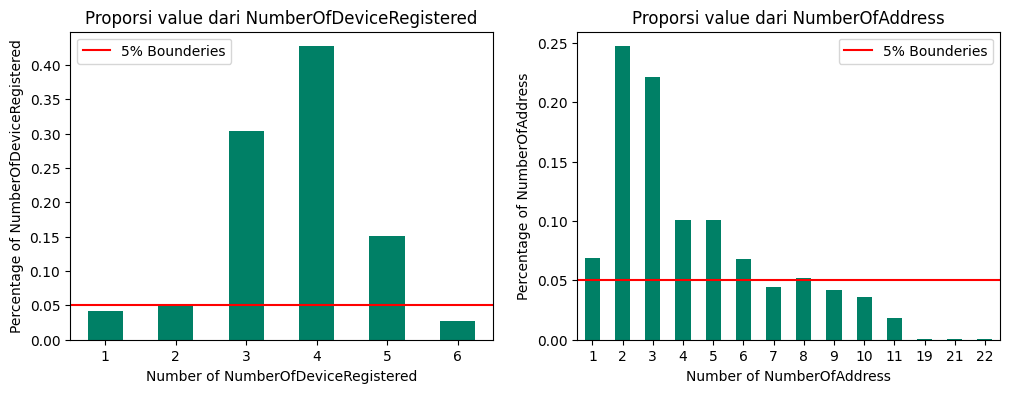

In [20]:
# kolom "NumberOfDeviceRegistered", "NumberOfAddress"
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

row1 = [ax1,ax2]
col1 = ["NumberOfDeviceRegistered", "NumberOfAddress"]
title1 = ['Proporsi value dari NumberOfDeviceRegistered','Proporsi value dari NumberOfAddress']

for i in zip(row1, col1, title1):
    # dfFrame
    temp_df1 = pd.Series(df[i[1]].value_counts() / len(df)).sort_index(ascending=True).plot(kind='bar', label='', ax=i[0], colormap="summer")
    # set title
    i[0].set_title(i[2])
    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')
    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)
    i[0].set_xlabel(f"Number of {i[1]}")
    # ylabel
    i[0].set_ylabel(f'Percentage of {i[1]}')
    # legend
    i[0].legend()


# show graph
plt.show()

__Insight :__
* Imbalance data, perbandingan label **non-churn** (83.64%) lebih banyak dibanding label **churn** (16.35%)
* 

#### **Dealing with The Problem**

Setelah memahami permasalahan data, maka selanjutnya kita akan melakukan preprocessing data dan feature engineering sebagai berikut:
* Membagi dataset kedalam data train set dan data test set
* Melakukan imputasi pada kolom missing value menggunakan metode ***Iterative Imputer*** untuk kolom "***`Tenure`***", "***`WarehouseToHome`***", "***`DaySinceLastOrder`***"
* Menghilangkan data outlier pada kolom "***Tenure***" dan "***WarehouseToHome***"
* Menghapus data duplikat pada dataset
* Mengganti kategori ***Mobile*** menjadi ***Mobile Phone*** menggunakan pipeline (*Agar ketika terdapat input data baru, model akan mengenali kategori "Mobile" menjadi "Mobile Phone"*)
* Melakukan encoding dan scalling untuk kolom "***`MaritalStatus`***", "***`PreferedOrderCat`***", "***`CashbackAmountClass`***"

##### > Melakukan Binning

In [21]:
# Melakukan binning pada kategori cashbackamount

bin_labels= ['Kecil', 'Sedang', 'Besar']

df['CashbackAmountCat']= pd.cut(x=df['CashbackAmount'], bins=[0, 120, 200, 324.99], labels=bin_labels, include_lowest=True)
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,CashbackAmountCat
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0,Sedang
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0,Sedang
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0,Sedang
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0,Besar
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0,Besar


In [22]:
df.groupby('CashbackAmountCat')['CashbackAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
CashbackAmountCat,,,,,,,,
Kecil,49.0,96.041633,37.646048,0.00,110.51,112.32,115.630,119.51
Sedang,2443.0,155.550225,20.854308,120.01,141.03,153.21,170.825,199.98
Besar,777.0,251.379022,37.170236,200.10,219.16,241.91,287.400,324.99


In [23]:
# colsMissing = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"]

# df = imputasi(df ,colsMissing) #<- Fungsi yang dibuat pada pengerjaan model ini

##### > Bagi dataset menjadi train set dan test set:

In [24]:
# Melakukan data splitting

# Membagi feature dan target
feature=df.drop(columns=['Churn']).columns
target='Churn'

# Membagi dataset df_seen dan df_unseen dari df
df_seen, df_unseen=train_test_split(df,
                                    stratify=df["Churn"].values, 
                                    test_size=0.2,random_state=0)

# Membagi dataset train dan validation dari df_seen
X_train, X_val, y_train, y_val=train_test_split(df_seen[feature], df_seen[target], 
                                                stratify=df_seen["Churn"].values, 
                                                test_size=0.2, random_state=0)

print(f"df_seen\nJumlah baris: {df_seen.shape[0]} baris\nJumlah kolom: {df_seen.shape[1]} kolom\n")
print(f"df_unseen\nJumlah baris: {df_unseen.shape[0]} baris\nJumlah kolom: {df_unseen.shape[1]} kolom\n")
print("=========================")
print(f"\nX_train\nJumlah baris: {X_train.shape[0]} baris\nJumlah kolom: {X_train.shape[1]} kolom\n")
print(f"X_val\nJumlah baris: {X_val.shape[0]} baris\nJumlah kolom: {X_val.shape[1]} kolom")

df_seen
Jumlah baris: 2615 baris
Jumlah kolom: 12 kolom

df_unseen
Jumlah baris: 654 baris
Jumlah kolom: 12 kolom


X_train
Jumlah baris: 2092 baris
Jumlah kolom: 11 kolom

X_val
Jumlah baris: 523 baris
Jumlah kolom: 11 kolom


In [25]:
# Membuat fitur x dan target y
X = df.drop(columns=['Churn'])
y = df['Churn']

##### > Melakukan Iterative Imputer

In [26]:
colsMissing = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"]

df_seen, df_unseen, X_train, X_val = imputasi(df_seen, df_unseen, X_train, X_val, colsMissing) #<- Fungsi yang dibuat pada pengerjaan model ini

In [27]:
# Melihat missing value
print(df_seen.isna().sum(), df_unseen.isna().sum())

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
CashbackAmountCat           0
dtype: int64 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
CashbackAmountCat           0
dtype: int64


In [28]:
# Melihat missing value
print(X_train.isna().sum(), X_val.isna().sum())

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
CashbackAmountCat           0
dtype: int64 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
CashbackAmountCat           0
dtype: int64


Setting parameter dasar untuk menginisialisasi experiment dan membuat pipeline transformasi:

In [29]:
# Bikin class untuk handling Data typo dan imputasi

class clearTypoImput(BaseEstimator, TransformerMixin):

    def _init_(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["PreferedOrderCat"].replace("Mobile", "Mobile Phone", inplace=True) #Replace kategori "Mobile" to "Mobile Phone"
        self.get_feature_names_out = X.columns
        self.X = X.to_numpy()
        return self

In [30]:
# # Membuat pipeline transformasi

# customPipeline = [
#     ("clearTypoImput", TransformerWrapper(transformer=clearTypoImput())), #<-
#     ("scaller", TransformerWrapper(include=["NumberOfDeviceRegistered", "NumberOfAddress", "Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"], transformer=StandardScaler())), #<-Proses encoding
#     ("onehot", TransformerWrapper(include=['MaritalStatus'], transformer=OneHotEncoder())), #<-Proses encoding
#     ("ordinal", TransformerWrapper(include=['CashbackAmountClass'], transformer=ce.OrdinalEncoder(mapping= ordinal_mapping))), #<-Proses encoding
#     ("binary", TransformerWrapper(include=['PreferedOrderCat'], transformer=ce.BinaryEncoder())) #<-Proses encoding
# ]

##### > Melakukan Encoding

In [31]:
# Ordinal mapping kolom cashbackamountclass

ordinal_mapping = [
    {'col':'CashbackAmountCat',
    'mapping':{
        'Kecil' : 0, 
        'Sedang': 1, 
        'Besar' : 2,
    }}
]

In [32]:
# Transformer
from sklearn.preprocessing import FunctionTransformer

# def a(x):
#     # return np.where(x=='Mobile', 'Mobile Phone', x)

transformer = ColumnTransformer([
    # ("clearTypoImput", FunctionTransformer(a), ['PreferedOrderCat']),
    ("scaller", StandardScaler(), ["NumberOfDeviceRegistered", "NumberOfAddress", "Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]),
    ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['CashbackAmountCat']),
    ('binary', ce.BinaryEncoder(), ['PreferedOrderCat'])
], remainder='passthrough') 

In [33]:
# Melihat preview hasil encoding
testing = pd.DataFrame(transformer.fit_transform(df_seen), columns=transformer.get_feature_names_out())
testing

,scaller__NumberOfDeviceRegistered,scaller__NumberOfAddress,scaller__Tenure,scaller__WarehouseToHome,scaller__DaySinceLastOrder,scaller__CashbackAmount,onehot__MaritalStatus_Married,onehot__MaritalStatus_Single,ordinal__CashbackAmountCat,binary__PreferedOrderCat_0,binary__PreferedOrderCat_1,binary__PreferedOrderCat_2,remainder__SatisfactionScore,remainder__Complain,remainder__Churn
0,1.297382,-0.464075,-0.142514,-0.172848,-0.718950,-0.533957,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.306826,2.595629,-1.090318,0.940004,-0.443690,-0.509591,1.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0
2,0.306826,0.300851,1.516142,1.681906,-0.443690,2.229450,1.0,0.0,2.0,0.0,1.0,0.0,4.0,0.0,0.0
3,1.297382,-0.464075,-0.142514,-1.038399,0.657351,0.485380,1.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,0.0
4,0.306826,-0.846537,0.212912,0.198103,-0.443690,-0.535165,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,0.306826,0.683314,1.042240,-0.296498,-0.994210,1.591508,1.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,0.0
2611,1.297382,2.213166,1.160715,-0.049197,0.932611,-0.146319,1.0,0.0,1.0,1.0,0.0,0.0,5.0,1.0,0.0
2612,1.297382,-0.464075,-0.616416,-0.172848,-0.112882,0.725213,1.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0
2613,1.297382,-1.229000,-1.208793,0.027381,-1.269470,-1.105647,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0


Feature Creation:

Feature Selection:

### **`Modeling`**

#### **Model Experiment**

##### Bandingkan model klasifikasi untuk mendapatkan benchmark model:

Metode klasifikasi yang akan kita coba sebagai penentuan model terbaik untuk dataset ini antara lain *Logistic Regression*, *KNearest Neighbour Classifier*, *Decision Tree Classifier*, *Random Forest Classifier*, *Ada Boost Classifier*, dan *Gradient Boosting Classifier*.

In [52]:
# Model yang digunakan
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)

# rangkuman model yang akan digunakan
models = [logreg,knn,dt,rf,ada,gbc]

In [36]:


# Membuat scoring untuk Fbeta 0.5 (F0.5)
fBeta_scorer = make_scorer(fbeta_score, beta=0.5)

# # Precision
# scorePrec=[]
# rataPrec=[]
# stdPrec=[]

# # Recall
# scoreRecall=[]
# rataRecall=[]
# stdRecall=[]

# F0.5
scoreFbeta=[]
rataFbeta=[]
stdFbeta=[]

for i in models:
    # smote_ = SMOTE(random_state=0)
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        # ('resampling', smote_),
        ('models',i)])
    
    # Matriks Precision
    # modelCVPrec=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="precision")
    # scorePrec.append(modelCVPrec)
    # rataPrec.append(modelCVPrec.mean())
    # stdPrec.append(modelCVPrec.std())

    # Matriks Recall
    # modelCVRec=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="recall")
    # scoreRecall.append(modelCVRec)
    # rataRecall.append(modelCVRec.mean())
    # stdRecall.append(modelCVRec.std())

    # Matriks F0.5 Score
    modelCVFbeta=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring=fBeta_scorer)
    scoreFbeta.append(modelCVFbeta)
    rataFbeta.append(modelCVFbeta.mean())
    stdFbeta.append(modelCVFbeta.std())

pd.DataFrame({'models':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting'],
              'mean F0.5':rataFbeta,
              'sdev F0.5':stdFbeta}).set_index('models').sort_values(by='mean F0.5',ascending=False)
              #'mean precision':rataPrec,
              #'sdev precision':stdPrec})
              #'mean recall':rataRecall,
              #'sdev recall':stdRecall})

,mean F0.5,sdev F0.5
models,,
Random Forest,0.712367,0.049068
Gradient Boosting,0.697901,0.020514
Ada,0.657095,0.046682
Logistic Regression,0.642897,0.047877
KNN,0.612427,0.029401
Decision Tree,0.595143,0.028227


Lakukan cek confussion matriks

In [ ]:
# # Confussion matrix

# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
# plt.subplots_adjust(wspace=0.4, hspace=0.4)

# for i, 

Lakukan optimasi model benchmark:

In [60]:
score_Fbeta = []

def y_pred_func(i):
    # smote_ = SMOTE(random_state=0)
    estimator=Pipeline([
        ('preprocess',transformer),
        # ('resampling', smote_),
        ('model',i)])
    # X_train,X_val
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_val),X_val)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting']):
    estimator,y_val,X_val = y_pred_func(i)
    y_predict = estimator.predict(X_val)#[:,1]
    score_Fbeta.append(fbeta_score(y_val, y_predict, beta=0.5))
    print(j,'\n', classification_report(y_val, y_predict))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting'],
             'Fbeta score':score_Fbeta}).set_index('model').sort_values(by='Fbeta score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00        56

    accuracy                           1.00       523
   macro avg       1.00      1.00      1.00       523
weighted avg       1.00      1.00      1.00       523

KNN 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       479
           1       1.00      1.00      1.00        44

    accuracy                           1.00       523
   macro avg       1.00      1.00      1.00       523
weighted avg       1.00      1.00      1.00       523

Decision Tree 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       1.00      1.00      1.00        87

    accuracy                           1.00       523
   macro avg       1.00      1.00      1.00       523
weighted avg       1.00      1

,Fbeta score
model,
Logistic Regression,1.0
KNN,1.0
Decision Tree,1.0
Random Forest,1.0
Ada,1.0
Gradient Boosting,1.0


Validasi silang 10-fold untuk mendapatkan rentang kinerja model:

In [41]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

**Model Intepretation**

* .....
* .....
* .....

**Model Limitation**

* .....
* .....
* .....


### **`Conclusion`**

Beberapa hal yang dapat disimpulkan yaitu:

* ....
* ....
* ....

### **`Recommendations`**

Hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

* ....
* ....
* ....